In [1]:
%load_ext autoreload
%autoreload 2

import os
import joblib
from pathlib import Path
from tempfile import TemporaryDirectory
from loguru import logger

import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from predictability.models import RITARegressor, PottsRegressor
from predictability.utils import update_environment_variables, assign_ssm_folds, assign_random_folds
from predictability.sm_utils import get_rita_embeddings, get_potts_emissions, read_sm_credentials
from predictability.constants import DATA_ROOT, PROJECT_ROOT

In [2]:
update_environment_variables("zsh")
read_sm_credentials("old")
DEFAULT_BUCKET = os.environ.get("AWS_DEFAULT_BUCKET")
SEED = 1337
n_folds = 10
lambda_values = [0.001, 0.01, 0.1, 0.9]
results_dir = PROJECT_ROOT / "results/regularization_effect"
results_dir.mkdir(exist_ok=True, parents=True)

In [3]:
datasets = [
    "AMY_BACSU/combinatorials",
    "AMY_BACSU/singles",
    "A2RQE2_9CELL",
    "CASP3_HUMAN_Roychowdhury_2020",
    "MK01_HUMAN_Brenan_2016",
    "AMIE_PSEAE_Wrenbeck_2017",
    "UBC9_HUMAN_Weile_2017",
    "SRC_HUMAN_Ahler_2019",
    "BLAT_ECOLX_Deng_2012",
    "BLAT_ECOLX_Stiffler_2015",
    "PTEN_HUMAN_Mighell_2018",
    "BLAT_ECOLX_Firnberg_2014"
]

In [4]:
rita_training_job_names = joblib.load(PROJECT_ROOT / "misc/rita_training_job_names.joblib")
potts_training_job_names = joblib.load(PROJECT_ROOT / "misc/potts_training_job_names.joblib")

In [5]:
potts_training_job_names = {
    "AMY_BACSU/combinatorials": "potts-regressor-12-09-53-35",
    "AMY_BACSU/singles": "potts-regressor-12-09-53-35",
    "A2RQE2_9CELL": "potts-regressor-08-16-14-48",
    "CASP3_HUMAN_Roychowdhury_2020": "potts-regressor-12-10-42-36",
    "MK01_HUMAN_Brenan_2016": "potts-regressor-12-10-42-42",
    "AMIE_PSEAE_Wrenbeck_2017": "potts-regressor-12-10-42-49",
    "UBC9_HUMAN_Weile_2017": "potts-regressor-12-10-42-54",
    "SRC_HUMAN_Ahler_2019": "potts-regressor-12-10-43-01",
    "BLAT_ECOLX_Deng_2012": "potts-regressor-12-10-43-07",
    "BLAT_ECOLX_Stiffler_2015": "potts-regressor-12-10-43-14",
    "PTEN_HUMAN_Mighell_2018": "potts-regressor-12-10-43-19",
    "BLAT_ECOLX_Firnberg_2014": "potts-regressor-12-10-43-25"
}

In [6]:
rita_training_job_names = {
    "AMY_BACSU/combinatorials": "huggingface-regressor-01-08-09-05",
    "AMY_BACSU/singles": "huggingface-regressor-01-08-09-00",
    "A2RQE2_9CELL": "huggingface-regressor-12-11-17-16",
    "CASP3_HUMAN_Roychowdhury_2020": "huggingface-regressor-12-10-42-32",
    "MK01_HUMAN_Brenan_2016": "huggingface-regressor-12-10-42-38",
    "AMIE_PSEAE_Wrenbeck_2017": "huggingface-regressor-12-10-42-44",
    "UBC9_HUMAN_Weile_2017": "huggingface-regressor-12-10-42-51",
    "SRC_HUMAN_Ahler_2019": "huggingface-regressor-12-10-42-56",
    "BLAT_ECOLX_Deng_2012": "huggingface-regressor-12-10-43-02",
    "BLAT_ECOLX_Stiffler_2015": "huggingface-regressor-12-10-43-09",
    "PTEN_HUMAN_Mighell_2018": "huggingface-regressor-12-10-43-16",
    "BLAT_ECOLX_Firnberg_2014": "huggingface-regressor-12-10-43-20"
}

In [7]:
targets = {
    "AMY_BACSU/combinatorials": "stain_activity",
    "AMY_BACSU/singles": "activity_dp3",
    "A2RQE2_9CELL": "activity-ker",
    "CASP3_HUMAN_Roychowdhury_2020": "DMS_score",
    "MK01_HUMAN_Brenan_2016": "DMS_score",
    "AMIE_PSEAE_Wrenbeck_2017": "DMS_score",
    "UBC9_HUMAN_Weile_2017": "DMS_score",
    "SRC_HUMAN_Ahler_2019": "DMS_score",
    "BLAT_ECOLX_Deng_2012": "DMS_score",
    "BLAT_ECOLX_Stiffler_2015": "DMS_score",
    "PTEN_HUMAN_Mighell_2018": "DMS_score",
    "BLAT_ECOLX_Firnberg_2014": "DMS_score"
}

In [8]:
# RITA
results = {
    "dataset": [],
    "model": [],
    "fold": [],
    "lambda_value": [],
    "spearman": [],
}
for ds in datasets:
    target = targets[ds]
    logger.info(f"Starting experiment on {ds}.")
    data = pd.read_csv(DATA_ROOT / f"{ds}/data.csv").reset_index()
    if ds == "AMY_BACSU/combinatorials":
        pass
    elif ds == "AMY_BACSU/singles":
        data["position"] = data["residue_number"]
    elif ds == "A2RQE2_9CELL":
        data["position"] = data["POS"]
    else:
        data["position"] = data["mutant"].map(lambda x: int(x[1:-1]))
    data = data.dropna(subset=[target])
    with TemporaryDirectory() as temp_dir:
        embeddings_path = get_rita_embeddings(
            path=temp_dir,
            dataset=ds,
            training_job_names=rita_training_job_names,
            default_bucket=DEFAULT_BUCKET
        )
        embeddings = np.load(embeddings_path)
        if ds == "AMY_BACSU/combinatorials":
            data = assign_random_folds(data, n_folds, random_seed=SEED)
            fold_name = "fold"
        else:
            data = assign_ssm_folds(data, n_folds=n_folds, position_col="position", random_seed=SEED)
            fold_name = "ssm_fold"
        for test_fold in range(n_folds):
            logger.info(f"Starting fold {test_fold}.")
            train_indices = np.where(data[fold_name] != test_fold)
            test_indices = np.where(data[fold_name] == test_fold)
            train_data = data[data[fold_name] != test_fold]
            test_data = data[data[fold_name] == test_fold]
            for lambda_reg in lambda_values:
                logger.info(f"Testing a lambda value of: {lambda_reg}.")
                model = RITARegressor(alpha=lambda_reg)
                model.fit(train_data, target=target, embeddings=embeddings[train_indices])
                test_predictions = model.predict(test_data, embeddings=embeddings[test_indices])
                spearman, _ = spearmanr(test_data[target].values, test_predictions)
                results["dataset"].append(ds)
                results["model"].append("RITA regressor")
                results["fold"].append(test_fold)
                results["lambda_value"].append(lambda_reg)
                results["spearman"].append(spearman)

2024-04-25 09:14:14.790 | INFO     | __main__:<module>:11 - Starting experiment on amylase/combinatorials.


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/floris/Library/Application Support/sagemaker/config.yaml


2024-04-25 09:14:26.638 | INFO     | __main__:<module>:37 - Starting fold 0.
2024-04-25 09:14:26.639 | INFO     | __main__:<module>:43 - Testing a lambda value of: 0.001.
2024-04-25 09:14:34.599 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-04-25 09:14:35.480 | INFO     | __main__:<module>:43 - Testing a lambda value of: 0.01.
2024-04-25 09:14:45.939 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-04-25 09:14:46.737 | INFO     | __main__:<module>:43 - Testing a lambda value of: 0.1.
2024-04-25 09:14:54.285 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-04-25 09:14:55.036 | INFO     | __main__:<module>:43 - Testing a lambda value of: 0.9.
2024-04-25 09:15:04.602 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-04-25 09:15:05.364 | INFO     | __main__:<module>:37 - Starting fold 1.
2024-04-25 09:15:05.405 | INFO     | __main__:<module>:43 - Testing a lambda value of: 0.001.
2024-04-25 09:15:12.920 | INFO     | predictabili

In [11]:
results_df = pd.DataFrame(results)
results_df.to_csv(results_dir / "rita_results.csv")

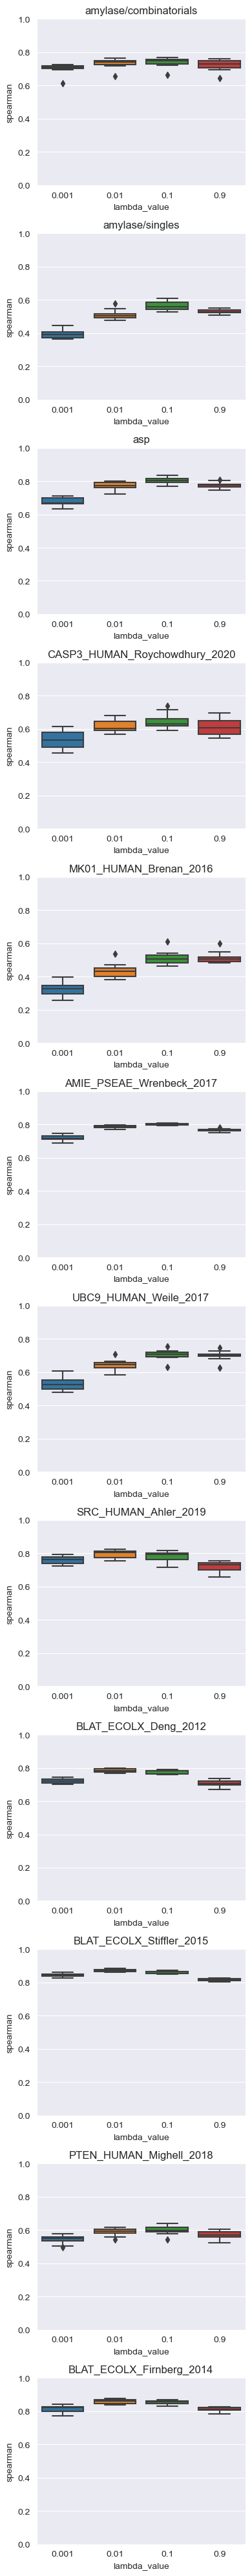

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(datasets), figsize=(4, 40))
for i, dataset in enumerate(datasets):
    df = results_df[results_df["dataset"] == dataset]

    sns.boxplot(df, x="lambda_value", y="spearman", ax=ax[i])
    ax[i].set_title(dataset)
    ax[i].set_ylim([0, 1])
fig.tight_layout()

In [9]:
results_df = pd.DataFrame(results)
results_df.to_csv(results_dir / "rita_results.csv")

# Rita last hidden state embeddings

In [6]:
# RITA
results = {
    "dataset": [],
    "model": [],
    "fold": [],
    "lambda_value": [],
    "spearman": [],
}
for ds in datasets:
    target = targets[ds]
    logger.info(f"Starting experiment on {ds}.")
    data = pd.read_csv(DATA_ROOT / f"{ds}/data.csv").reset_index()
    data["embedding_index"] = list(range(len(data)))
    embedding_indices = data["embedding_index"].values
    if ds == "AMY_BACSU/combinatorials":
        pass
    elif ds == "AMY_BACSU/singles":
        data["position"] = data["residue_number"]
    elif ds == "A2RQE2_9CELL":
        data["position"] = data["POS"]
    else:
        data["position"] = data["mutant"].map(lambda x: int(x[1:-1]))
    data = data.dropna(subset=[target])
    with TemporaryDirectory() as temp_dir:
        embeddings_path = get_rita_embeddings(
            path=temp_dir,
            dataset=ds,
            training_job_names=rita_training_job_names,
            default_bucket=DEFAULT_BUCKET
        )
        embeddings = np.load(embeddings_path)
        if ds == "AMY_BACSU/combinatorials":
            data = assign_random_folds(data, n_folds, random_seed=SEED)
            fold_name = "fold"
        else:
            data = assign_ssm_folds(data, n_folds=n_folds, position_col="position", random_seed=SEED)
            fold_name = "ssm_fold"
        for test_fold in range(n_folds):
            logger.info(f"Starting fold {test_fold}.")
            train_indices = np.where(data[fold_name] != test_fold)
            test_indices = np.where(data[fold_name] == test_fold)
            train_data = data[data[fold_name] != test_fold]
            test_data = data[data[fold_name] == test_fold]
            for lambda_reg in lambda_values:
                logger.info(f"Testing a lambda value of: {lambda_reg}.")
                model = RITARegressor(alpha=lambda_reg)
                model.fit(train_data, target=target, embeddings=embeddings[train_indices])
                test_predictions = model.predict(test_data, embeddings=embeddings[test_indices])
                spearman, _ = spearmanr(test_data[target].values, test_predictions)
                results["dataset"].append(ds)
                results["model"].append("RITA regressor")
                results["fold"].append(test_fold)
                results["lambda_value"].append(lambda_reg)
                results["spearman"].append(spearman)

2024-02-29 14:28:23.192 | INFO     | __main__:<module>:10 - Starting experiment on CASP3_HUMAN_Roychowdhury_2020.


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/floris/Library/Application Support/sagemaker/config.yaml


2024-02-29 14:28:34.364 | INFO     | __main__:<module>:23 - Starting fold 0.
2024-02-29 14:28:34.367 | INFO     | __main__:<module>:29 - Testing a lambda value of: 0.001.
2024-02-29 14:28:42.465 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-02-29 14:28:42.827 | INFO     | __main__:<module>:29 - Testing a lambda value of: 0.01.
2024-02-29 14:28:53.992 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-02-29 14:28:54.368 | INFO     | __main__:<module>:29 - Testing a lambda value of: 0.1.
2024-02-29 14:29:02.411 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-02-29 14:29:02.681 | INFO     | __main__:<module>:29 - Testing a lambda value of: 0.9.
2024-02-29 14:29:12.932 | INFO     | predictability.models:fit:253 - Fitting ridge
2024-02-29 14:29:13.270 | INFO     | __main__:<module>:23 - Starting fold 1.
2024-02-29 14:29:13.301 | INFO     | __main__:<module>:29 - Testing a lambda value of: 0.001.
2024-02-29 14:29:22.637 | INFO     | predictabili

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv(results_dir / "rita_results.csv")

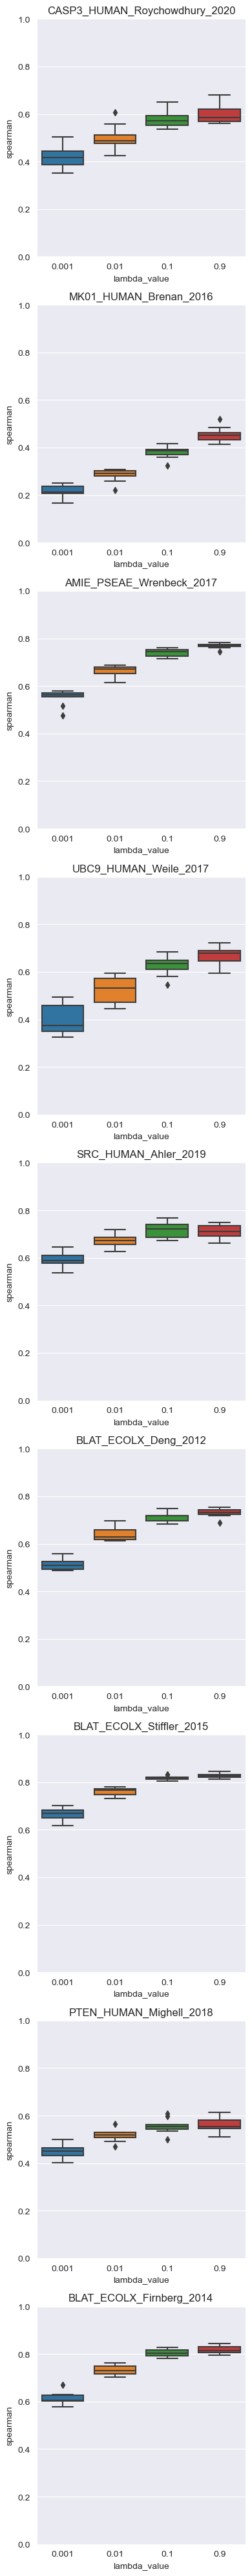

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(datasets), figsize=(4, 40))
for i, dataset in enumerate(datasets):
    df = results_df[results_df["dataset"] == dataset]

    sns.boxplot(df, x="lambda_value", y="spearman", ax=ax[i])
    ax[i].set_title(dataset)
    ax[i].set_ylim([0, 1])
fig.tight_layout()

In [14]:
# Potts
results = {
    "dataset": [],
    "model": [],
    "fold": [],
    "lambda_value": [],
    "spearman": [],
}
for ds in datasets:
    target = targets[ds]
    logger.info(f"Starting experiment on {ds}.")
    data = pd.read_csv(DATA_ROOT / f"{ds}/data.csv").reset_index()
    data["embedding_index"] = list(range(len(data)))
    embedding_indices = data["embedding_index"].values
    if ds == "AMY_BACSU/combinatorials":
        pass
    elif ds == "AMY_BACSU/singles":
        data["position"] = data["residue_number"]
    elif ds == "A2RQE2_9CELL":
        data["position"] = data["POS"]
    else:
        data["position"] = data["mutant"].map(lambda x: int(x[1:-1]))
    data = data.dropna(subset=[target])
    with TemporaryDirectory() as temp_dir:
        potts_path = get_potts_emissions(
            path=temp_dir,
            dataset=ds,
            training_job_names=potts_training_job_names,
            default_bucket=DEFAULT_BUCKET
        )
        if ds == "AMY_BACSU/combinatorials":
            data = assign_random_folds(data, n_folds, random_seed=SEED)
            fold_name = "fold"
        else:
            data = assign_ssm_folds(data, n_folds=n_folds, position_col="position", random_seed=SEED)
            fold_name = "ssm_fold"
        for test_fold in range(n_folds):
            logger.info(f"Starting fold {test_fold}.")
            train_data = data[data[fold_name] != test_fold]
            test_data = data[data[fold_name] == test_fold]
            for lambda_reg in lambda_values:
                logger.info(f"Testing a lambda value of: {lambda_reg}.")
                model = PottsRegressor(potts_path=Path(potts_path), encoder="energies", alpha=lambda_reg)
                model.fit(train_data, target=target)
                test_predictions = model.predict(test_data)
                spearman, _ = spearmanr(test_data[target].values, test_predictions)
                results["dataset"].append(ds)
                results["model"].append("Augmented Potts")
                results["fold"].append(test_fold)
                results["lambda_value"].append(lambda_reg)
                results["spearman"].append(spearman)

2024-04-25 11:19:11.508 | INFO     | __main__:<module>:11 - Starting experiment on amylase/combinatorials.
2024-04-25 11:19:37.388 | INFO     | __main__:<module>:38 - Starting fold 0.
2024-04-25 11:19:37.392 | INFO     | __main__:<module>:42 - Testing a lambda value of: 0.001.
2024-04-25 11:19:37.393 | INFO     | predictability.models:__init__:149 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmprdwvaqzw
2024-04-25 11:19:46.567 | INFO     | __main__:<module>:42 - Testing a lambda value of: 0.01.
2024-04-25 11:19:46.577 | INFO     | predictability.models:__init__:149 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmprdwvaqzw
2024-04-25 11:19:54.731 | INFO     | __main__:<module>:42 - Testing a lambda value of: 0.1.
2024-04-25 11:19:54.732 | INFO     | predictability.models:__init__:149 - Loading Potts model locally from: /var/folders/d8/bxgj52rj3w934zctbjr8v2hh0000gn/T/tmprdwvaqzw
2024-04-25 11:20:02.626 | INFO

In [15]:
results_df = pd.DataFrame(results)
results_df.to_csv(results_dir / "potts_results.csv")

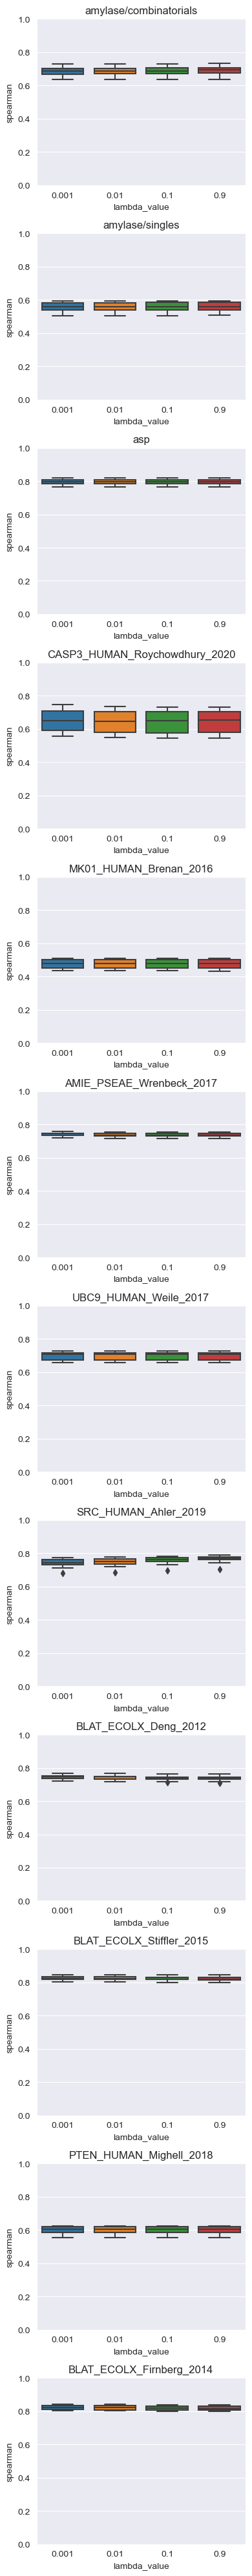

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(datasets), figsize=(4, 40))
for i, dataset in enumerate(datasets):
    df = results_df[results_df["dataset"] == dataset]

    sns.boxplot(df, x="lambda_value", y="spearman", ax=ax[i])
    ax[i].set_title(dataset)
    ax[i].set_ylim([0, 1])
fig.tight_layout()